In [1]:
show_plots = True

In [2]:
# Imports
import sys
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import osmnx as ox
import numpy as np
import os
import matplotlib.pyplot as plt
# quetzal-specific stuff
from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder
from quetzal.io.gtfs_reader import importer
from quetzal.model import stepmodel
from datetime import datetime

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
input_path = training_folder + 'input/'
input_folder = training_folder + 'inputs/'
model_path = training_folder + 'model/'
output_path = training_folder + 'outputs/'

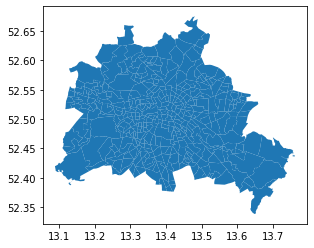

In [4]:
# Load the model with ber_zones
sm = stepmodel.read_json(model_path + 'zones')
if not type(sm.zones) == GeoDataFrame:
    sm.zones = GeoDataFrame(sm.zones, crs=sm.epsg)
if show_plots: sm.zones.plot()

## Road network

Build the road network graph from OpenStreetMap data and save it into GeoDataFrames

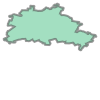

In [5]:
# To-Do think whether it might make sense to increase the buffer to cover Brandenburg
hull = unary_union([x.buffer(1e-3) for x in sm.zones['geometry']])
hull

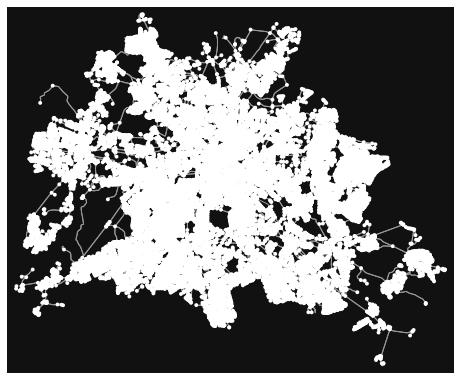

In [6]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
drive = ox.graph_from_polygon(hull, network_type='drive')
# Plot it
if show_plots: ox.plot_graph(drive)

In [7]:
# Use OSMNX function to create GeoDataFrames from graph
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [8]:
# Let's have a look at the results
road_nodes.head(2)

y          x  street_count  ref highway  \
osmid                                                     
172539  52.565205  13.335501             3  NaN     NaN   
172545  52.567033  13.346605             4  NaN     NaN   

                         geometry  
osmid                              
172539  POINT (13.33550 52.56521)  
172545  POINT (13.34661 52.56703)

In [9]:
#road_links.plot(figsize=(16,9))
road_links.head(2)

osmid lanes             name    highway maxspeed  \
u      v        key                                                       
172539 34694265 0    4610047     2  Holländerstraße   tertiary       50   
       34694336 0    5117633     2   Gotthardstraße  secondary       50   

                     oneway   length  \
u      v        key                    
172539 34694265 0     False  237.653   
       34694336 0     False  687.484   

                                                              geometry  ref  \
u      v        key                                                           
172539 34694265 0    LINESTRING (13.33550 52.56521, 13.33560 52.565...  NaN   
       34694336 0    LINESTRING (13.33550 52.56521, 13.33565 52.565...  NaN   

                    bridge width tunnel junction access service area est_width  
u      v        key                                                             
172539 34694265 0      NaN   NaN    NaN      NaN    NaN     NaN  NaN       NaN  
       34694336 0      NaN   NaN    NaN      NaN    NaN     NaN  NaN       NaN

In [10]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data

In [11]:
road_nodes = road_nodes.reset_index()
road_links = road_links.reset_index()

In [12]:
# Rename columns and make them type string for later operations
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

In [13]:
# Create a cleaner object and run cleaning functions on it
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [14]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#oc.clean_geometries() # Doesn't work, but let's hope we don't need it
oc.fix_nodeset_consistency()

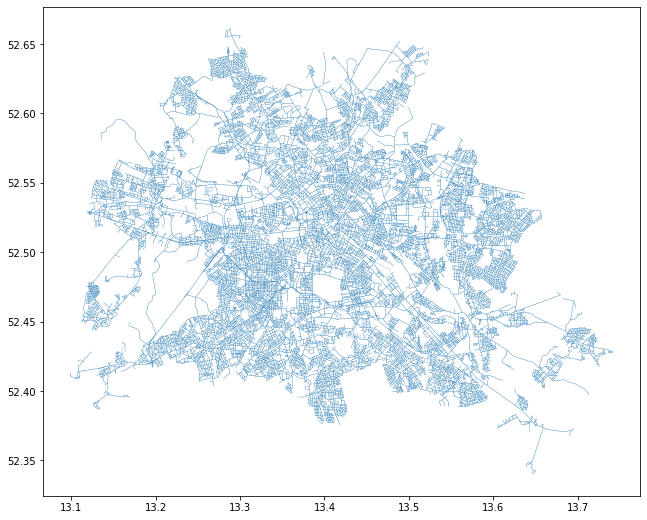

In [15]:
if show_plots: road_links.plot(figsize=(16,9), linewidth=0.2)

Our road network is now saved in `oc.nodes` and `oc.links`

## Public Transport

For PT, we need to convert GTFS feeds into links and nodes GeoDataFrames

In [16]:
# Load the GTFS feed
full_feed = importer.GtfsImporter(path='../../input/vbb_gtfs.zip', dist_units='m')
# downloaded from http://vbb.de/vbbgtfs
#print(full_feed.stops)

In [17]:
# Restrict the feed to a given date in order to analyse a
# typical work day and not the whole week
start = min(full_feed.calendar['start_date'])
end = max(full_feed.calendar['end_date'])
feed_r = full_feed.restrict(
    dates=[start,start] # the dates must be within the feed start and end dates
)

In [18]:
feed_r.calendar_dates

service_id      date exception_type
0           876  20220909              1
1          1809  20220909              1
2          1779  20220909              1
3          1942  20220909              1
4          1724  20220909              1
...         ...       ...            ...
1291        547  20220909              1
1292       1440  20220909              1
1293        850  20220909              1
1294       1215  20220909              1
1295       1276  20220909              1

[1296 rows x 3 columns]

In [19]:
# We can also restrict it to hours
# TODO: nothing between 8 and 9 am?
time_range = ['16:00:00', '17:00:00']
feed_t = feed_r.restrict(time_range=time_range)
# print(feed_t.stops)

In [20]:
# And we can restrict it spacially if we write a suitable function
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [21]:
# Give the hourly restricted feed to the spatial restriction
feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

In [22]:
feed_s.calendar_dates[feed_s.calendar_dates['service_id']=='2']

service_id      date exception_type
170          2  20220909              1
818          2  20220909              1

In [23]:
feed_s.calendar_dates[feed_s.calendar_dates['service_id']=='1384']

service_id      date exception_type
249       1384  20220909              1
897       1384  20220909              1

In [24]:
### deal with gtfs feed specific error by keeping only first occurrance of service_id

dict = {}
for i in range(len(feed_s.calendar_dates['service_id'])):
    id = feed_s.calendar_dates['service_id'].iloc[i]
    if id in dict.keys():
        dict[id] += 1
    else:
        dict[id] = 1
print(any([dict[key]>1 for key in  dict.keys()]), dict)

# keep only first occurence of service_id by filtering calendar_dates
bool_indices = [x not in list(feed_s.calendar_dates['service_id'].iloc[0:n]) for n, x in enumerate(feed_s.calendar_dates['service_id'])]
feed_s.calendar_dates = feed_s.calendar_dates[bool_indices]

dict = {}
for i in range(len(feed_s.calendar_dates['service_id'])):
    id = feed_s.calendar_dates['service_id'].iloc[i]
    if id in dict.keys():
        dict[id] += 1
    else:
        dict[id] = 1
print(any([dict[key]>1 for key in  dict.keys()]), dict)


True {'1779': 2, '1724': 2, '182': 2, '554': 2, '545': 2, '1742': 2, '892': 2, '49': 2, '482': 2, '296': 2, '511': 2, '1766': 2, '66': 2, '523': 2, '514': 2, '1669': 2, '50': 2, '1356': 2, '2': 2, '1361': 2, '686': 2, '470': 2, '1181': 2, '1663': 2, '1580': 2, '1881': 2, '38': 2, '1588': 2, '256': 2, '253': 2, '98': 2, '932': 2, '1384': 2, '525': 2, '1618': 2, '760': 2, '1172': 2, '821': 2, '718': 2, '1051': 2, '1900': 2, '1175': 2, '346': 2, '153': 2, '1717': 2, '406': 2, '1591': 2, '993': 2, '1875': 2, '178': 2, '720': 2, '713': 2, '680': 2, '589': 2, '154': 2, '176': 2, '755': 2, '44': 2, '1365': 2, '255': 2, '94': 2, '251': 2, '1397': 2, '1033': 2, '177': 2, '1582': 2, '1359': 2, '180': 2, '315': 2, '1344': 2, '1419': 2, '1756': 2, '990': 2, '371': 2, '1878': 2, '1621': 2, '1608': 2, '127': 2, '1569': 2, '179': 2, '1827': 2, '25': 2, '547': 2}
False {'1779': 1, '1724': 1, '182': 1, '554': 1, '545': 1, '1742': 1, '892': 1, '49': 1, '482': 1, '296': 1, '511': 1, '1766': 1, '66': 1, '

In [25]:
# GTFS feeds are very complex. Have a look at Wikipedia for its structure
# We neet to perform some operations in order to transform it into a graph
feed = feed_s.copy()
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterize stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters


In [26]:
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

100%|██████████| 707/707 [00:08<00:00, 88.30it/s] 


In [27]:
# We can build links and nodes now from the frequency graph
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

export geometries in epsg: 32633


In [28]:
feed_frequencies.links.head(2)

index                        a      trip_id  link_sequence  departure_time  \
0      0  de:11000:900092201:1:51  10141_109_0              1         54498.0   
1      1  de:11000:900093201:1:51  10141_109_0              2         54654.0   

   pickup_type                        b  arrival_time  drop_off_type   time  \
0            0  de:11000:900093201:1:51       54630.0              0  132.0   
1            0  de:11000:900094101:1:51       54768.0              0  114.0   

   ...  wheelchair_accessible bikes_allowed agency_id route_short_name  \
0  ...                      1             1         1     S1-10141_109   
1  ...                      1             1         1     S1-10141_109   

  route_long_name route_type  route_color route_text_color route_desc  \
0             NaN        109          NaN              NaN        NaN   
1             NaN        109          NaN              NaN        NaN   

                                            geometry  
0  LINESTRING (13.29032 52.63226, 13.30762 52.61729)  
1  LINESTRING (13.30762 52.61729, 13.32109 52.60626)  

[2 rows x 29 columns]

In [29]:
feed_frequencies.nodes.head(1)

stop_id stop_code                     stop_name stop_desc  \
27  de:11000:900160004:3:54       NaN  S+U Lichtenberg Bhf (Berlin)       NaN   

    location_type      parent_station  wheelchair_boarding platform_code  \
27              0  de:11000:900160004                    0            17   

                              zone_id  level_id                   geometry  
27  5656_S+U_Lichtenberg_Bhf_(Berlin)     100.0  POINT (13.49649 52.51000)

In [30]:
# Make stop_id the unique index of nodes
# Use cluster_id if you built clusters before
feed_frequencies.nodes.set_index('stop_id', inplace=True)
len(feed_frequencies.nodes.loc[feed_frequencies.nodes.index.duplicated()])

0

In [31]:
feed_frequencies.links['route_type'].unique()

array([ 109,  700,  900,  100, 1000,  400,    2], dtype=int64)

In [32]:
# Rename the route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}
#Additional route types used in VBB Data:
ex_mapping = {100:'rail', 109:'rail', 400:'subway', 700:'bus', 900:'tram', 1000:'ferry'}
mapping.update(ex_mapping)

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

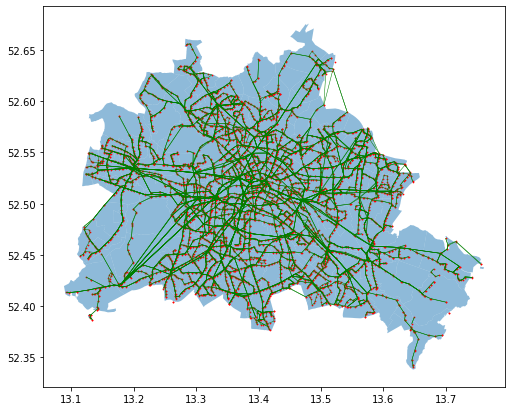

In [33]:
if show_plots:
    # Plot the results using matplotlib notation
    ax = sm.zones.plot(alpha=0.5, figsize=[17, 7])
    ax = feed_frequencies.links.plot(linewidth=0.5, color='green', ax=ax)
    plot= feed_frequencies.nodes.plot(markersize=0.5, color='red', ax=ax)

## Create the transport model

We have the network DataFrames and need to put them into a model now, to be able to run quetzal functions on it, that go beyond the scope of only one DataFrame

In [34]:
# Add road network
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway', 'maxspeed']]
sm.road_nodes = oc.nodes[['geometry']]

In [35]:
# Assign PT network to it with the columns we need
sm.links = feed_frequencies.links[['trip_id', 'a', 'b', 'link_sequence', 'time', 'headway',
                                   'pattern_id', 'route_id', 'service_id', 'direction_id',
                                   'agency_id', 'route_type', 'route_color', 'geometry']]
sm.nodes = feed_frequencies.nodes[['geometry', 'stop_name', 'location_type']]

## Check integrity

Run quetzals integrity check functions to see if the networks are alright

In [36]:
# check and fix name collision in the indicies
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


In [37]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 28141it [00:09, 2817.01it/s]
reversed: 28141it [00:09, 2905.58it/s]
28086it [00:09, 2823.03it/s]


In [38]:
# Fix PT
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

dropped circular lines: ['19042_100_6', '17345_700_1', '17413_700_0', '19043_100_6', '17318_700_2', '17328_700_1', '17453_700_1', '17292_700_1', '19049_100_5', '17346_700_0', '17295_700_0', '17295_700_3', '17292_700_0', '17619_700_1', '17538_700_0', '17346_700_1', '19019_700_0', '17375_700_0', '17385_700_1', '17427_900_2', '17421_900_2', '17531_700_0', '17348_700_3', '17348_700_2', '17329_700_0', '19049_100_3', '17372_700_0', '17382_700_1']


In [39]:
# Test
sm.integrity_test_all(errors='raise')

passed: integrity_test_circular_lines
passed: integrity_test_collision


28086it [00:03, 8731.38it/s] 


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


28086it [00:11, 2420.74it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


## Cluster PT stops

Clustering has the advantage of reducing the model's file size and computational expenses. You can also leaf this step out.
To-Do: is n_clusters = 300 the best number?

In [40]:
# Clusterize nodes
# sm.preparation_clusterize_nodes(n_clusters=800)
# sm.nodes.head(1)

In [41]:
len(sm.nodes)

6842

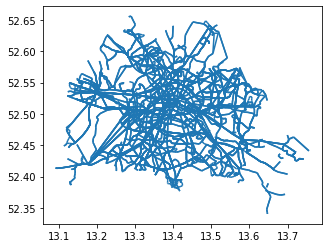

In [42]:
if show_plots: sm.links.plot()

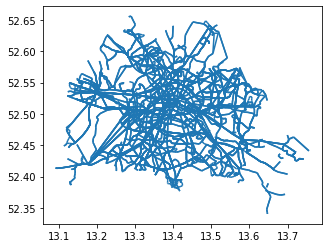

In [43]:
# Now, some links might go from one stop to the same # To-Do: This does seem to remove to many links. Check back later if this is problematic.
sm.links = sm.links.loc[sm.links['a']!=sm.links['b']]
if show_plots: sm.links.plot()

In [44]:
# Fix network integrity again
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()

In [45]:
# Check the integrity again
sm.integrity_test_all(errors='raise')

passed: integrity_test_circular_lines
passed: integrity_test_collision


28086it [00:02, 9419.88it/s] 


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


28086it [00:12, 2322.37it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


In [46]:
# print(sorted([str(key)+": "+str(type(sm.__dict__[key]).__name__) for key in sm.__dict__.keys()]))
# Re-index nodes to prevent collision
sm.nodes.index = ['n_'+str(i) for i in sm.nodes.index]
sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
sm.links['a'] = 'n_' + sm.links['a'].astype(str)
sm.links['b'] = 'n_' + sm.links['b'].astype(str)
# print(sorted([str(key)+": "+str(type(sm.__dict__[key]).__name__) for key in sm.__dict__.keys()]))

In [47]:
sm.links.sample()

trip_id                             a  \
link_1013  17290_700_0  n_node_de:11000:900022251::1   

                                      b  link_sequence  time  headway  \
link_1013  n_node_de:11000:900021181::1             43  60.0     1200   

            pattern_id   route_id service_id  direction_id agency_id  \
link_1013  17290_700_0  17290_700       1779             1       796   

          route_type route_color  \
link_1013        bus         NaN   

                                                    geometry  
link_1013  LINESTRING (13.31753 52.51756, 13.32043 52.52019)

## Network connectors

We have road and PT links and nodes. Now we need to connect them for people to be able to switch and enter as they want

In [48]:
# Create a footpaths table
sm.preparation_footpaths(max_length=1000, n_clusters=(len(sm.zones)*2))
sm.footpaths.head(3), len(sm.footpaths)

(                                       a                             b  \
 footpath_0  n_node_de:11000:900260608::1  n_node_de:11000:900260607::2   
 footpath_1  n_node_de:11000:900183510::1  n_node_de:11000:900183510::2   
 footpath_2  n_node_de:11000:900053171::1  n_node_de:11000:900053153::1   
 
                                                      geometry      length  \
 footpath_0  LINESTRING (13.693482 52.371709, 13.68284 52.3...  733.573110   
 footpath_1  LINESTRING (13.724868 52.425131, 13.727003 52....  172.101835   
 footpath_2  LINESTRING (13.097383 52.413383, 13.109863 52....  850.095748   
 
             voronoi         time  
 footpath_0        1   880.287732  
 footpath_1        1   206.522202  
 footpath_2        1  1020.114897  ,
 59792)

In [49]:
# store old zone geometry
zones = sm.zones.copy()
# change zone geoemtry to circle around pop centroid, to have the following step run with respect to this centroid
sm.zones['geometry'] = [(Point(lon,lat) if lon>0 and lat>0 else g.centroid).buffer(1e-6) for lon,lat,g in zip(sm.zones['popCentroidLon'].values, sm.zones['popCentroidLat'].values, sm.zones['geometry'].values)]

# Create access and egress links (ntlegs)
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3, # km/h
    long_leg_speed=7, # km/h
    threshold=threshold, # m
    zone_to_transit=True, # zone centroid - PT connectors
    zone_to_road=True, # zone centroid - road connectors
    n_ntlegs=5 # number of connectors
)

# restore old geometry
sm.zones['geometry'] = zones['geometry']

In [50]:
# This is how the new tables look like
# Re-index them too
sm.zone_to_transit.index = ['ztt_'+str(i) for i in sm.zone_to_transit.index]
sm.zone_to_transit.sample(1)

a              b  rank    distance  \
ztt_3641  n_node_de:11000:900120016::4  zone_02040503     3  555.207125   

                                                   geometry direction  \
ztt_3641  LINESTRING (13.44752436032102 52.5210198719280...   eggress   

          speed_factor  short_leg_speed  long_leg_speed     speed        time  \
ztt_3641      1.666144                3               7  4.998432  399.874545   

           walk_time  
ztt_3641  399.874545

In [51]:
sm.zone_to_road.index = ['ztr_'+str(i) for i in sm.zone_to_road.index]
sm.zone_to_road.sample(1)

a           b  rank    distance  \
ztr_1640  zone_08020619  1831154068     3  185.054168   

                                                   geometry direction  \
ztr_1640  LINESTRING (13.44306160018739 52.4584232318800...    access   

          speed_factor  short_leg_speed  long_leg_speed  speed        time  \
ztr_1640       0.96191                3               7    3.0  222.065001   

           walk_time  
ztr_1640  222.065001

In [52]:
sm.road_to_transit.index = ['rtt_'+str(i) for i in sm.road_to_transit.index]
sm.road_to_transit.sample(1)

a                             b  rank  distance  \
rtt_36164  3880659180  n_node_de:11000:900075154::2     0  7.378542   

                                                    geometry direction  \
rtt_36164  LINESTRING (13.440344 52.489467, 13.4402452 52...   eggress   

           speed_factor  short_leg_speed  long_leg_speed  speed     time  \
rtt_36164      0.192075                3               7    3.0  8.85425   

           walk_time  
rtt_36164    8.85425

# Networkcaster

## Rail

In [53]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]
rail.preparation_cast_network(dumb_cast=True)

nearest_link: 100%|██████████| 68420/68420 [00:01<00:00, 61456.03it/s]


## Road

In [54]:
road = sm.copy()


In [55]:
road.links['route_type'].unique()

array(['rail', 'bus', 'tram', 'ferry', 'subway'], dtype=object)

In [56]:
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [57]:
len(sm.road_nodes), len(sm.road_links)

(28086, 135354)

In [58]:
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

17363_700_3: 100%|██████████| 441/441 [01:41<00:00,  4.35it/s]


## both road and rail

In [59]:
sm.nodes

geometry  \
n_node_de:11000:900053206::2  POINT (13.13343 52.41172)   
n_node_de:11000:900007154::2  POINT (13.39966 52.54238)   
n_node_de:11000:900049151::2  POINT (13.23628 52.43227)   
n_node_de:11000:900057107::1  POINT (13.36650 52.49578)   
n_node_de:11000:900074258::1  POINT (13.40168 52.39211)   
...                                                 ...   
n_node_de:11000:900192510::1  POINT (13.50700 52.45863)   
n_node_de:11000:900054105::6  POINT (13.34295 52.47784)   
n_node_de:11000:900130517::2  POINT (13.42689 52.56477)   
n_node_de:11000:900011105::2  POINT (13.34337 52.56334)   
n_node_de:11000:900175555::1  POINT (13.58424 52.50517)   

                                                   stop_name  location_type  
n_node_de:11000:900053206::2     Hahn-Meitner-Platz (Berlin)              0  
n_node_de:11000:900007154::2          Demminer Str. (Berlin)              0  
n_node_de:11000:900049151::2           Wolzogenstr. (Berlin)              0  
n_node_de:11000:900057107::1         Dennewitzplatz (Berlin)              0  
n_node_de:11000:900074258::1        John-Locke-Str. (Berlin)              0  
...                                                      ...            ...  
n_node_de:11000:900192510::1      Schnellerstr. 135 (Berlin)              0  
n_node_de:11000:900054105::6  S+U Innsbrucker Platz (Berlin)              0  
n_node_de:11000:900130517::2               Binzstr. (Berlin)              0  
n_node_de:11000:900011105::2          Londoner Str. (Berlin)              0  
n_node_de:11000:900175555::1              Adolfstr. (Berlin)              0  

[6842 rows x 3 columns]

In [60]:
both = road.copy()
both.links = pd.concat([road.links, rail.links])

In [61]:
both.analysis_lines(line_columns='all')

# monitoring

In [62]:
links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

road.build_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']

Deprecated: replaced by analysis_lines


In [63]:
lines.head(2)

trip_id  headway   pattern_id   route_id service_id  direction_id  \
0  10231_700_0      600  10231_700_0  10231_700       1779             1   
1  10231_700_1      600  10231_700_1  10231_700       1779             1   

  agency_id route_type  link_straight_length  \
0         1        bus              0.021824   
1         1        bus              0.037392   

                                            geometry    length  \
0  LINESTRING (13.39539 52.38668, 13.39533 52.386...  0.050177   
1  LINESTRING (13.36345 52.47668, 13.36340 52.476...  0.057750   

   straight_length  length_ratio  
0         0.021824      2.299125  
1         0.030081      1.544448

In [64]:
# summary
title = str(
    (lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int).to_dict()
)[1:-1]

Text(0.5, 1.0, "'link_straight_length': 0, 'straight_length': 0, 'length': 0")

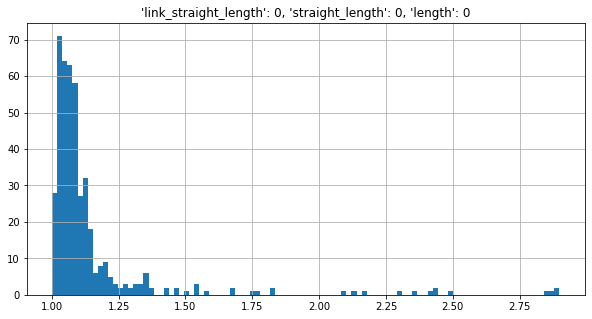

In [65]:
ax = lines['length_ratio'].hist(bins=100, figsize=[10, 5])
ax.set_title(title)

In [66]:
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile5/tile21/tile21.png'
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile21/tile21/tile5.png'

import matplotlib.pyplot as plt
def plot_networkcaster(raw, processed, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    
    # print(0)
    buffer = raw.copy()
    # buffer_width = max(raw.zones['geometry'].apply(lambda g: max(abs(g.bounds[0]-g.bounds[2]), abs(g.bounds[1]-g.bounds[3]))))/2
    # buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(buffer_width))
    
    # print(1)
    # raw.road_nodes.plot(markersize=0.3, color='black', ax=ax.flat[0])
    raw.road_links.plot(linewidth=0.3, color='green', ax=ax.flat[0])
    ax.flat[0].set_title("Road network")
    
    # print(2)
    raw.links.plot(ax=ax.flat[1], color='blue', linewidth=0.5)
    gpd.GeoSeries(raw.nodes.geometry, crs=4326).plot(ax=ax.flat[1], color='black', markersize=10)
    gpd.GeoSeries(raw.disaggregated_nodes.geometry, crs=4326).plot(ax=ax.flat[1], color='pink', markersize=2)
    # if interested one could add disaggregated_nodes and connect them to center node.
    ax.flat[1].set_title("GTFS")

    # print(3)
    raw.road_links.plot(color='green', linewidth=0.5, ax=ax.flat[2])
    raw.links.plot(ax=ax.flat[2], color='blue', linewidth=0.2)
    ax.flat[2].set_title("raw GTFS & road network")

    # print(4)
    # gpd.GeoSeries(processed.road_links['geometry'], crs=4326).plot(ax=ax.flat[3], color='green', linewidth=0.5)
    # gpd.GeoSeries(processed.links['geometry'], crs=4326).plot(ax=ax.flat[3], color='blue', linewidth=0.5)
    processed.road_links.plot(ax=ax.flat[3], color='green', linewidth=0.5)
    processed.links.plot(ax=ax.flat[3], color='blue', linewidth=0.5)
    ax.flat[3].set_title("Processed GTFS & Road Network")
    
    # print(5)
    for _ax in ax.flat:
        _ax.set_xlim(buffer.zones['geometry'].total_bounds[0], buffer.zones['geometry'].total_bounds[2])
        _ax.set_ylim(buffer.zones['geometry'].total_bounds[1], buffer.zones['geometry'].total_bounds[3])

    return fig

In [67]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in both.__dict__.keys() if type(both.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in both.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    both.__dict__[key] = gpd.GeoDataFrame(both.__dict__[key], crs=both.epsg)
broken_gdf_keys = [key for key in both.__dict__.keys() if type(both.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in both.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:",broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['footpaths', 'networkcaster_neighbors', 'networkcaster_road_access', 'road_to_transit', 'zone_to_transit', 'zone_to_road']
Successfully fixed.


could not add basemap: cannot identify image file <_io.BytesIO object at 0x000002533E4FE6D0>


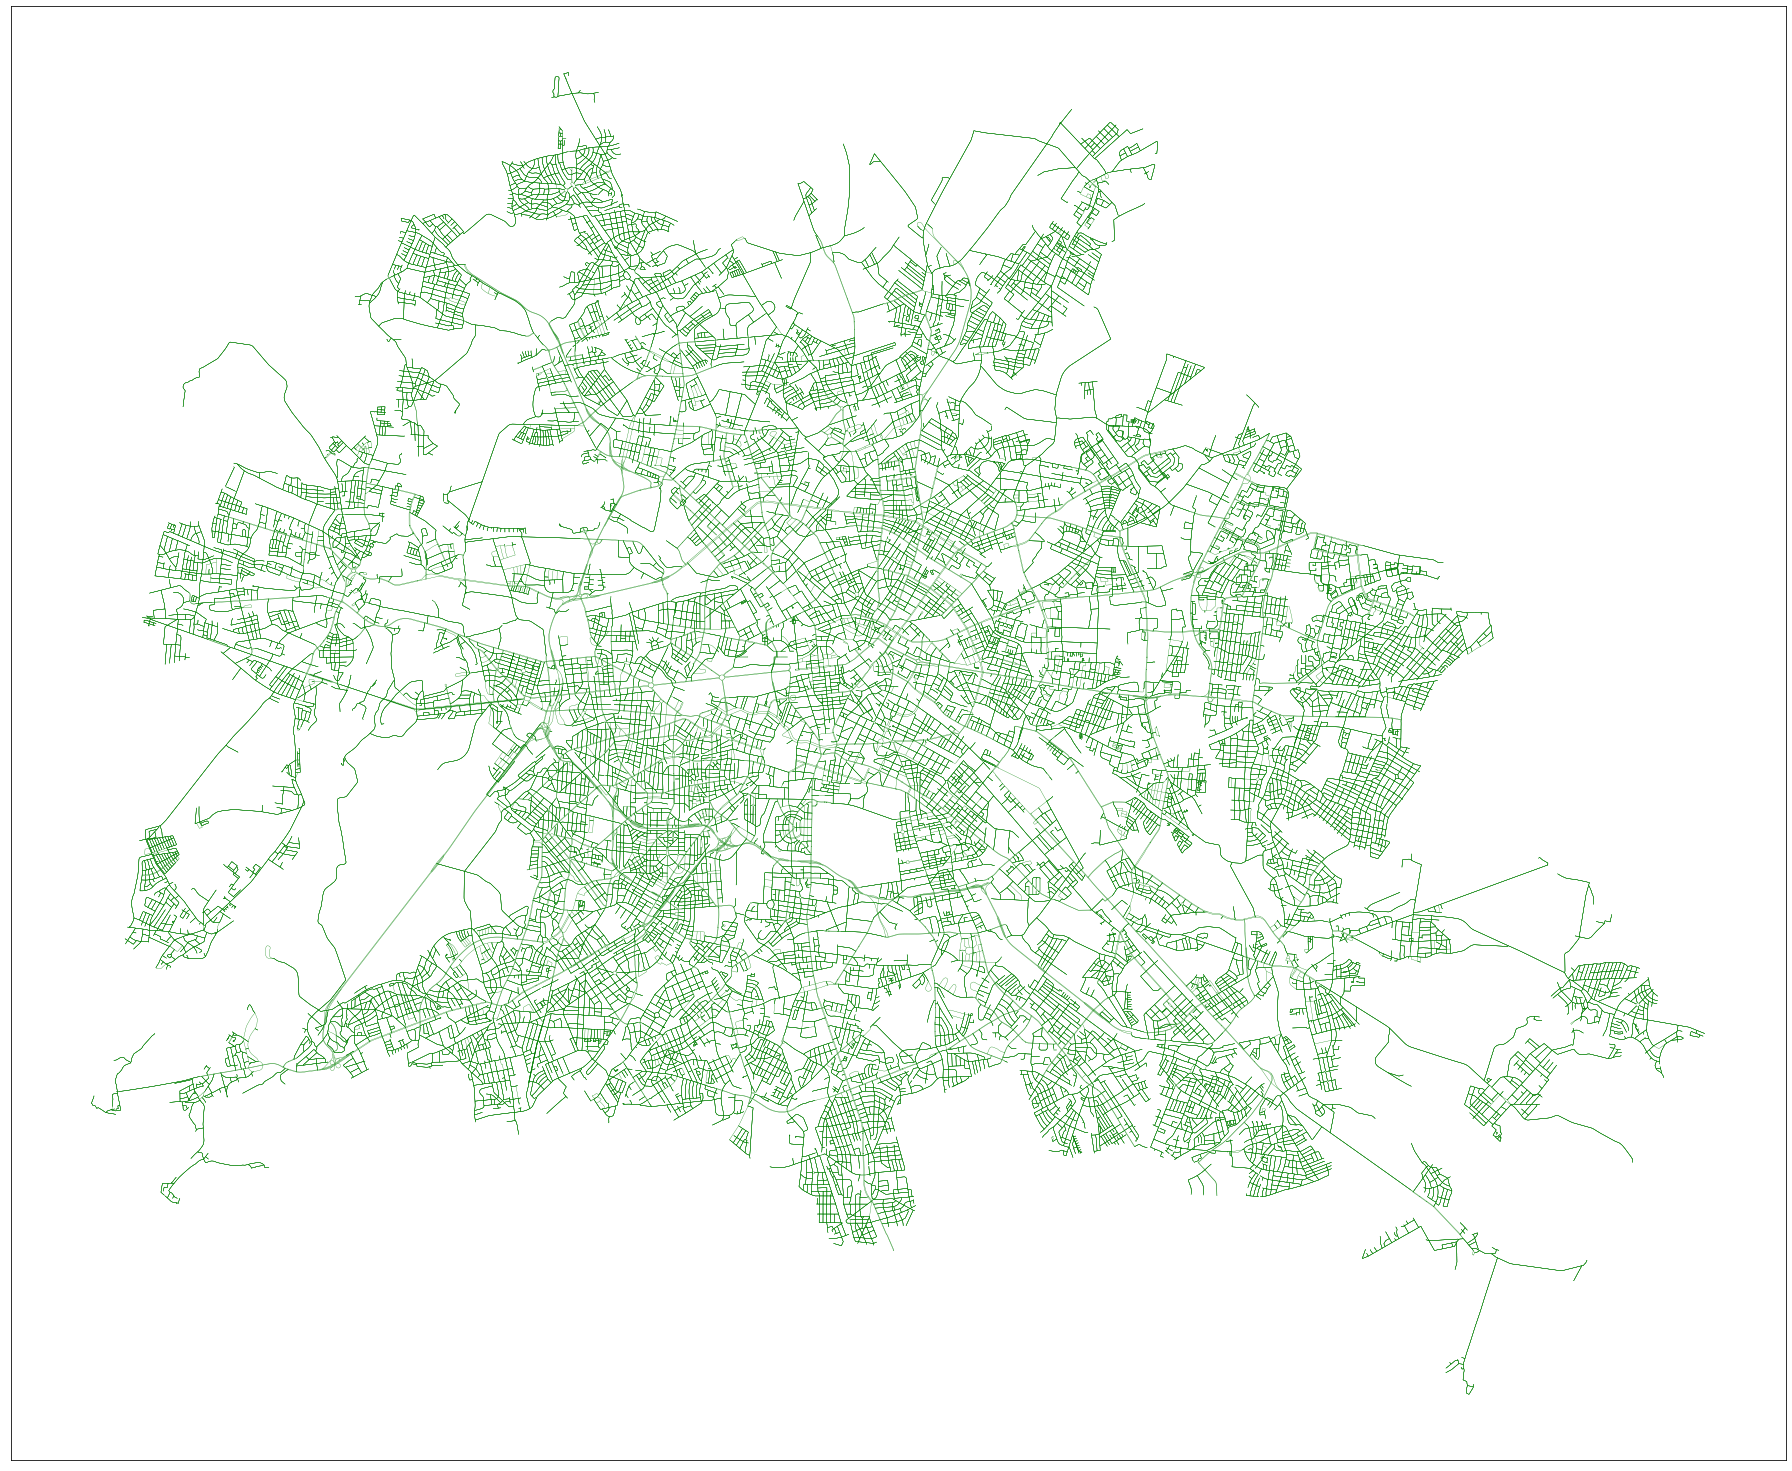

In [68]:
if show_plots:
    fig, ax = plt.subplots(1, 1,  figsize=[25, 25], tight_layout=True) 
    url='http://a.basemaps.cartocdn.com/light_nolabels/tile4/tile16/tile11.png'
    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile5/tile21/tile21.png'
    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile17/tile21/tile5.png'
    url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile1/tile1/tile1.png'

    buffer = sm.copy()
    buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(0.04))
    sm.plot('road_links', linewidth=0.3, color='green',
                    ax=ax, basemap_url=url
                    , figsize=[20,20])

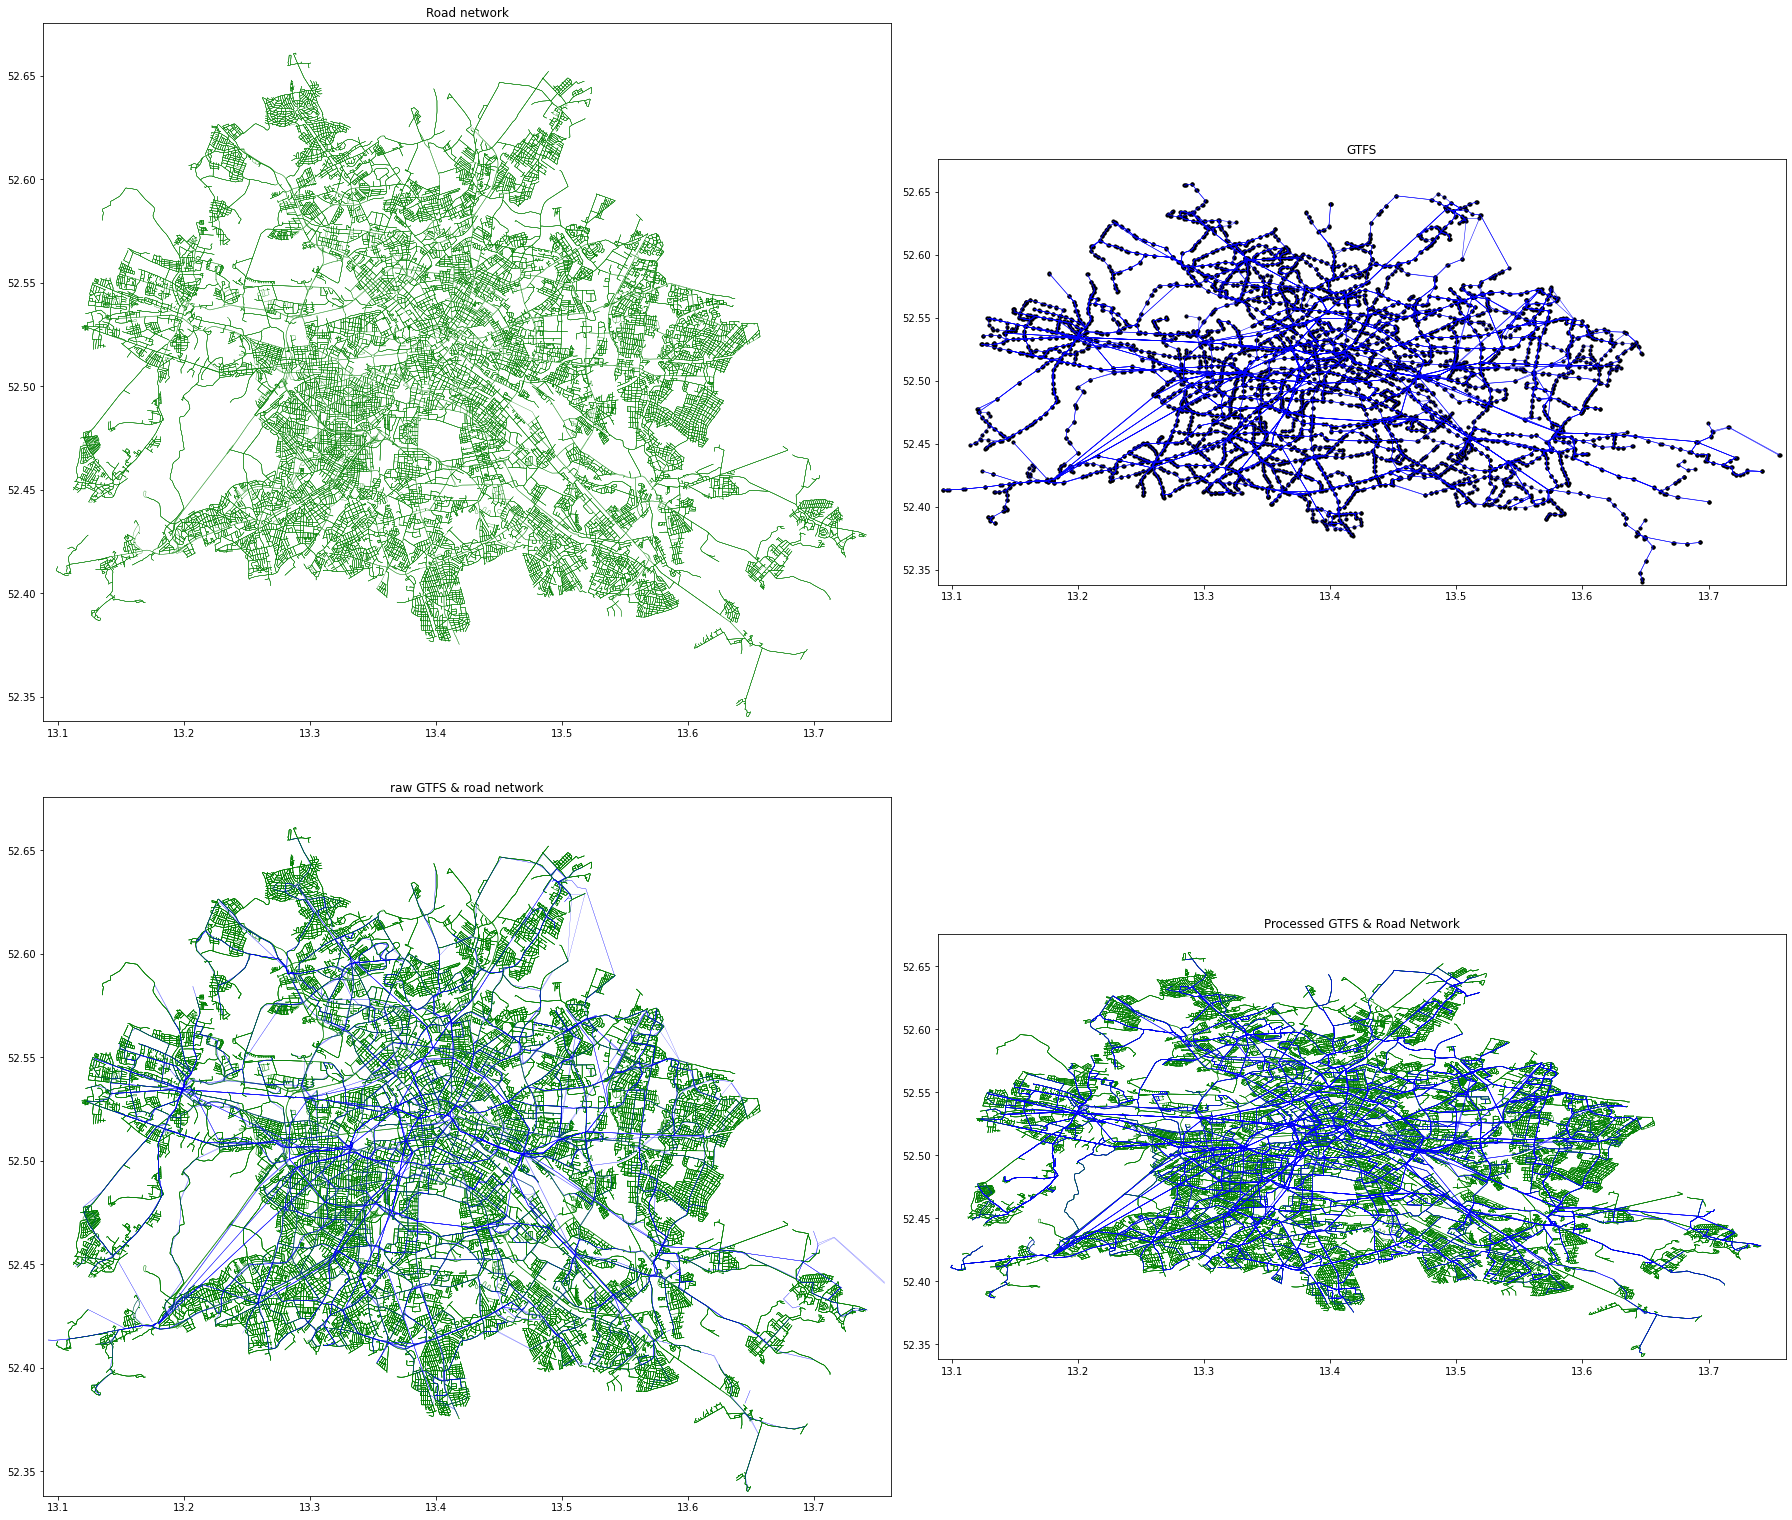

In [69]:
if show_plots:
    fig = plot_networkcaster(raw=sm, processed=both, url=url)

## Add validation Data:

In [70]:
sm = both

### read in validation data

link_id               elem_nr         vnp         nnp  vst  \
1575  51440005_T0067690  51440005_51440007.01  51440005.0  51440007.0  0.0   

       bst vricht  ebene str_typ strklasse1 strklasse strklasse2  \
1575  81.0      B    0.0       S         II         G       STRA   

               str_name    bezirk stadtteil  dtvw_kfz  dtvw_lkw  \
1575  Neuköllner Straße  Neukölln     Rudow   29600.0     990.0   

                                               geometry  
1575  LINESTRING (13.47795 52.42965, 13.47803 52.429...

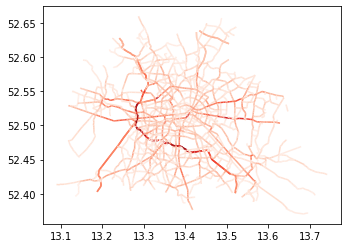

In [71]:
traffic_validation = gpd.read_file(input_path + "validation/Verkehrsmengen.shp")
traffic_validation.to_crs(epsg=4326, inplace=True)
traffic_validation.plot(cmap="Reds", column='dtvw_kfz')
traffic_validation.sample(1)


## Match validation data to road network
- logic: create buffers around road_network and obtain intersection between the network polygons to match road links from validation data to road links from network
- for an even more accurate matching one could use the non-simplified links.

In [72]:
def gridSearchIntersections (
        intersectionOf:GeoSeries, 
        intersectionWith:GeoSeries, 
        gridDimensions:tuple=(1,1), 
        outerBox:tuple=False,
        calc_margin_on:GeoSeries=None,
        plot:bool=True
        ) -> list:
    """
    Function that speeds up the search for an array of polygon within a GeoDataFrame
    returns GeoDataFrame with original geometry replaced with intersections geometry
    
    outerBox = (min_x, min_y, max_x, max_y)
    insideBufferInMeters should be at least circle radius around if looking for intersection of circles with something
    """
    if plot: print('Generate plots.')
    print('set up margins for grid search')
    t = datetime.now()

    if not type(outerBox) == tuple:
        outerBox = intersectionWith.total_bounds
    outerBoxPoly = Polygon([(outerBox[0], outerBox[1]), (outerBox[2], outerBox[1]), (outerBox[2], outerBox[3]), (outerBox[0], outerBox[3])])
    
    # continue here maybe use intersectionWith
    if not type(calc_margin_on) in (GeoSeries, GeoDataFrame):
        calc_margin_on = intersectionOf
    if not type(calc_margin_on) == GeoDataFrame:
        calc_margin_on = GeoDataFrame(geometry=calc_margin_on, crs=calc_margin_on.crs)
    
    # prepare margin
    m_prep = [[abs(t[0]-t[1]) for t in x.xy] for x in calc_margin_on['geometry']]
    calc_margin_on['x_ext'] = [x[0] for x in m_prep]
    calc_margin_on['y_ext'] = [x[1] for x in m_prep]
    
    dim_x, dim_y = gridDimensions[0], gridDimensions[1]
    # stepsize_x, stepsize_y = (outerBox[2]-outerBox[0]-2*margin_x)/dim_x,  (outerBox[3]-outerBox[1]-2*margin_y)/dim_y
    stepsize_x, stepsize_y = (outerBox[2]-outerBox[0])/dim_x,  (outerBox[3]-outerBox[1])/dim_y

    # xsteps = [margin_x+outerBox[0]+stepsize_x*(n) for n in range(dim_x+1)]
    # ysteps = [margin_y+outerBox[1]+stepsize_y*(n) for n in range(dim_y+1)]
    xsteps = [outerBox[0]+stepsize_x*(n) for n in range(dim_x+1)]
    ysteps = [outerBox[1]+stepsize_y*(n) for n in range(dim_y+1)]
    

    print('time spent to set up correct margins', datetime.now()-t)
    print("set up grid cells")

    grid = [[] for i in range(dim_x)]
    gridPolys = []
    t = datetime.now()
    for i in range(dim_x):
        if (100 * i / dim_x) % 20 == 0 and i > 0:
            print(round(100*i/ dim_x), "% Time remaining:", (datetime.now()-t)*(1- i/dim_x)/(i/ dim_x), 
            "% Time remaining:", (datetime.now()-t)*(1- i/dim_x)/(i/ dim_x),
            'Time elapsed:', datetime.now()-t)
        
        gridCol_of = calc_margin_on.cx[xsteps[i] : xsteps[i+1], : ]
        margin_x = gridCol_of['x_ext'].max() if len(gridCol_of)>0 else 0.0

        gridCol = intersectionWith.cx[xsteps[i]-margin_x : xsteps[i+1]+margin_x, : ]
        
        if len(gridCol)==0:
            grid[i].extend([gridCol for j in range(dim_y)])
            gridPolys.extend([Polygon([]) for j in range(dim_y)])
            continue

        for j in range(dim_y):

            gridCell_of = gridCol_of.cx[ : , ysteps[j] : ysteps[j+1]]
            margin_y = gridCell_of['y_ext'].max() if len(gridCell_of)>0 else 0.0
            gridCell = gridCol.cx[ : , ysteps[j]-margin_y : ysteps[j+1]+margin_y]
            grid[i].append(gridCell) 
            
            if plot:
                gridPolys.append(Polygon([\
                    (xsteps[i]-margin_x, ysteps[j]-margin_y), \
                    (xsteps[i]-margin_x, ysteps[j+1]+margin_y), \
                    (xsteps[i+1]+margin_x, ysteps[j+1]+margin_y), \
                    (xsteps[i+1]+margin_x, ysteps[j]-margin_y)\
                ]))
    
    print(datetime.now() - t, "time spent to set up grid cells",gridDimensions, '=',gridDimensions[0]*gridDimensions[1], '')

    t = datetime.now()

    intersection_df = intersectionOf.copy()
    intersections = []

    time_lookup = datetime.now()-datetime.now()
    time_intersection = datetime.now()-datetime.now()

    print('start creating intersections')
    len_io = len(intersectionOf)
    for n, geom in zip(range(len_io), list(intersectionOf)):
        if (n*100 / len_io) % 2 > ((n+1)*100 / len_io) % 2 and n > 0:
            print(round(100*n/ len_io), 
            "% Time remaining:", 
            (datetime.now()-t)*(1- n/len_io)/(n/ len_io),
            'Time elapsed:', datetime.now()-t,
            'total look_up time:', time_lookup,
            'total intersection time:', time_intersection)
        
        # geom = intersectionOf.iloc[n]
        t_ = datetime.now()
        centroidCoords = geom.centroid.coords[0]
        try:
            i = next(n for n,x in enumerate(xsteps) if x>centroidCoords[0]) -1
        except:
            i = -1
        try:
            j = next(n for n,y in enumerate(ysteps) if y>centroidCoords[1]) -1
        except:
            j = -1
        time_lookup += datetime.now()- t_

        t_ = datetime.now()
        intersection = [] if -1 in (i,j) and not geom.intersects(outerBoxPoly) else [(n,g) for n,g in zip(grid[i][j].index, grid[i][j].intersection(geom)) if not g.is_empty]
        intersection_areas = [(n, x.area) for n,x in intersection]
        intersection_union_area = unary_union([x for n,x in intersection]).area
        time_intersection += datetime.now()- t_
        intersections.append((intersection_areas, intersection_union_area))

        
    print(datetime.now() - t, "time spent to create intersection",len(intersectionOf),
            'total look_up time:', time_lookup,
            'total intersection time:', time_intersection)

    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
        intersectionOf.plot(ax=ax, color="red", alpha=.3)
        intersectionWith.plot(ax=ax, color="blue", alpha=.3)
        GeoSeries([outerBoxPoly], crs=4326).plot(ax=ax, color="none", edgecolor="black", linewidth=2)
        GeoSeries(gridPolys, crs=4326).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=.5)
    
    return intersections    

### choose buffer parameter
- the coice matters! 
- be as precise as possible (its better to have fewer validation data, than wrong validation data!)


#### Match validation data to sm.road_links

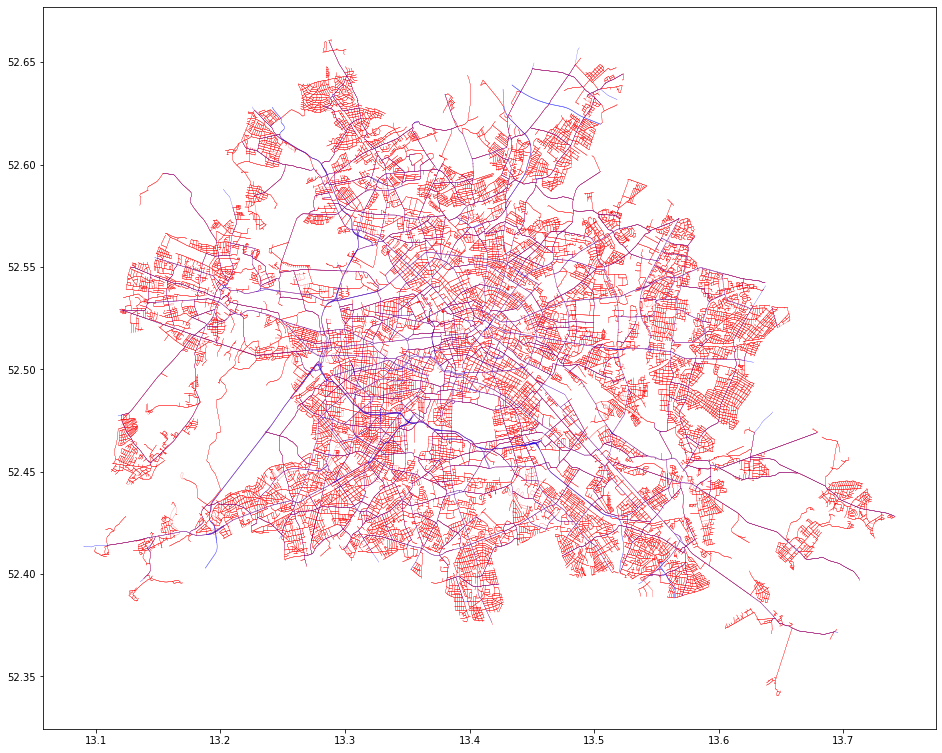

In [73]:
# define the width of each polygon. the choice of this parameter matters! b
validation_buffer = 0.0001
# for each link in road network compute its validation traffic data by:
network_buff = sm.road_links.buffer(validation_buffer*.5)
validation_buff = traffic_validation.buffer(validation_buffer)


if show_plots:
    fig, ax = plt.subplots(figsize = (16,16))
    network_buff.plot(ax=ax, color="red")
    validation_buff.plot(ax=ax, color="blue", alpha=0.75)


In [74]:
# for each link in road network with buffer calculate retrieve its intersection with validation data gdf
# its best to make the grid very fine so that grid creation and intersection time are balanced
# function still take over 10 Minutes.
road_links_validation_intersections = \
    gridSearchIntersections(
        intersectionOf=network_buff, 
        intersectionWith=validation_buff, 
        gridDimensions=(70,70), 
        calc_margin_on=sm.road_links['geometry'],
        plot=False
        )


set up margins for grid search
time spent to set up correct margins 0:00:10.640448
set up grid cells
20 % Time remaining: 0:01:02.567665 % Time remaining: 0:01:02.567665 Time elapsed: 0:00:15.641916
40 % Time remaining: 0:00:50.358992 % Time remaining: 0:00:50.358992 Time elapsed: 0:00:33.572661
60 % Time remaining: 0:00:34.970308 % Time remaining: 0:00:34.970308 Time elapsed: 0:00:52.455463
80 % Time remaining: 0:00:17.760031 % Time remaining: 0:00:17.760031 Time elapsed: 0:01:11.040124
0:01:24.933413 time spent to set up grid cells (70, 70) = 4900 
start creating intersections
2 % Time remaining: 0:09:38.509546 Time elapsed: 0:00:11.805961 total look_up time: 0:00:00.267639 total intersection time: 0:00:07.738016
4 % Time remaining: 0:08:14.268582 Time elapsed: 0:00:20.593890 total look_up time: 0:00:00.604086 total intersection time: 0:00:16.176508
6 % Time remaining: 0:07:15.829113 Time elapsed: 0:00:27.818005 total look_up time: 0:00:00.842029 total intersection time: 0:00:23.1340

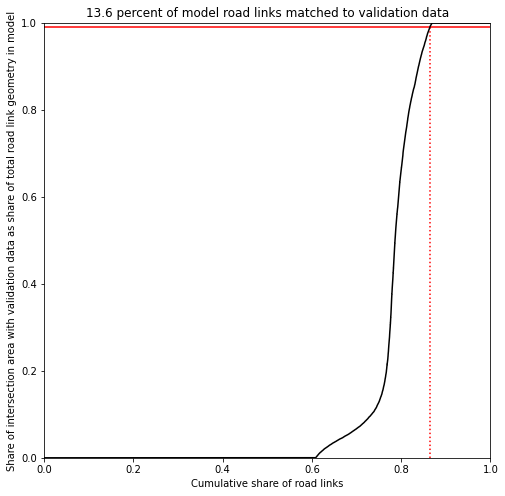

In [75]:
# now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# by adding a threshold of how large the  be at least
total_intersection_areas = [sum([y for n, y in x[0]]) for x in road_links_validation_intersections]
tvd = list(traffic_validation['dtvw_kfz'])

sm.road_links['validation_load'] = \
    [sum([x/t*tvd[n] for n,x in xsections]) \
    if xarea > (nb.area * 0) else 0 \
    for (xsections, xarea),t,nb in zip(road_links_validation_intersections, total_intersection_areas, network_buff)] 

sm.road_links['validation_share'] = [xarea/nb.area for (xsections, xarea), nb in zip(road_links_validation_intersections, network_buff)] 

threshold = 0.99
sm.road_links['validation_threshold'] = sm.road_links['validation_share'] > threshold

share = sum(sm.road_links['validation_threshold'])/len(sm.road_links)

fig, ax = plt.subplots(ncols=1, figsize = (8,8))
ax.plot([x/len(sm.road_links) for x in range(len(sm.road_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(road_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
ax.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
ax.vlines(1-share, 0, threshold, linestyles ="dotted", colors ="red")
ax.set_title(str(round(share*100,1)) + ' percent of model road links matched to validation data')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_ylabel('Share of intersection area with validation data as share of total road link geometry in model')
ax.set_xlabel('Cumulative share of road links')

plt.savefig(output_path+'plots/road_validation_match_stats'+'_dpi300.png', dpi=300)
plt.savefig(output_path+'plots/road_validation_match_stats'+'_dpi200.png', dpi=200)
plt.savefig(output_path+'plots/road_validation_match_stats'+'_dpi100.png', dpi=100)          


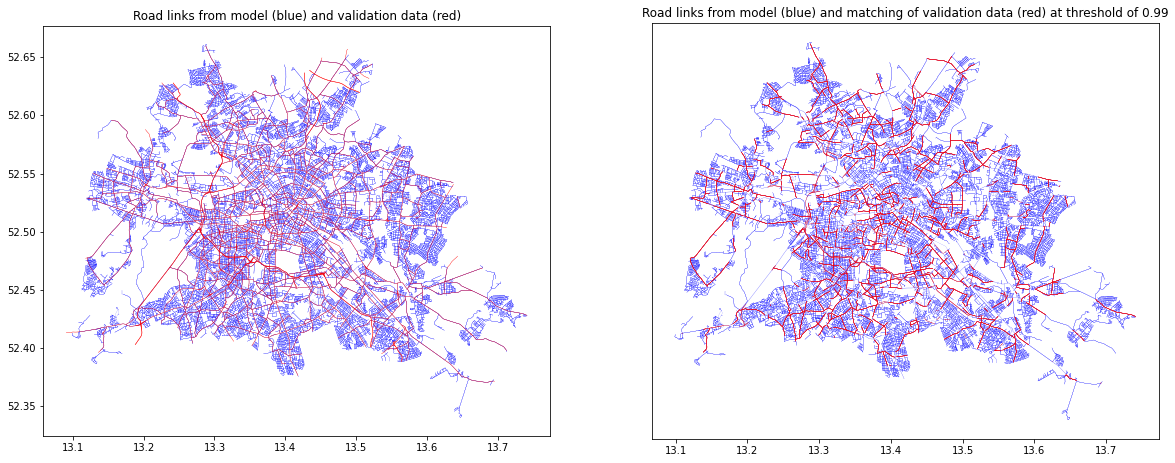

In [76]:
if show_plots:
    fig, ax = plt.subplots(ncols=2, figsize = (20,16))

    sm.road_links.plot(ax=ax.flat[0], color="blue", alpha=1, linewidth=.1)
    traffic_validation.plot(ax=ax.flat[0], color="red", linewidth=0.4)
    # network_buff.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
    # validation_buff.plot(ax=ax.flat[0], color="red", linewidth=0.5)
    ax.flat[0].set_title('Road links from model (blue) and validation data (red)')

    sm.road_links.plot(ax=ax.flat[1], color="blue", alpha=1, linewidth=.1)
    sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.3)
    # network_buff.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
    # network_buff[sm.road_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
    ax.flat[1].set_title('Road links from model (blue) and matching of validation data (red) at threshold of '+str(threshold))
    ax.flat[1].axes.get_yaxis().set_visible(False)

    # sm.road_links.plot(ax=ax.flat[2], color="blue", alpha=1, linewidth=.1)
    # traffic_validation.plot(ax=ax.flat[2], color="black", linewidth=0.4)
    # sm.road_links[sm.road_links['validation_threshold']].plot(ax=ax.flat[2], color="red", linewidth=0.3)

    plt.savefig(output_path+'plots/road_validation_match'+'_dpi300.png', dpi=300)
    plt.savefig(output_path+'plots/road_validation_match'+'_dpi200.png', dpi=200)
    plt.savefig(output_path+'plots/road_validation_match'+'_dpi100.png', dpi=100)          





#### Match validation data to sm.loaded_links

In [77]:
# validation_buffer = 0.0003
# # for each link in road network compute its validation traffic data by:
# network_buff = sm.loaded_links.buffer(validation_buffer*.5)
# validation_buff = traffic_validation.buffer(validation_buffer)

# if show_plots:
#     fig, ax = plt.subplots(figsize = (16,16))
#     network_buff.plot(ax=ax, color="blue")
#     validation_buff.plot(ax=ax, color="red", alpha=0.5)


In [78]:
# # for each link in road network with buffer calculate retrieve its intersection with validation data gdf
# # its best to make the grid very fine so that grid creation and intersection time are balanced
# # function still take over 10 Minutes.
# loaded_links_validation_intersections = \
#     gridSearchIntersections(
#         intersectionOf=network_buff, 
#         intersectionWith=validation_buff, 
#         gridDimensions=(25,15), 
#         calc_margin_on=sm.loaded_links['geometry'],
#         plot=False
#         )


In [79]:
# # now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# # make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# # by adding a threshold of how large the  be at least
# threshold = 0.99
# total_intersection_areas = [sum([y for n, y in x[0]]) for x in loaded_links_validation_intersections]
# tvd = list(traffic_validation['dtvw_kfz'])

# sm.loaded_links['validation_load'] = \
#     [sum([x/t*tvd[n] for n,x in xsections]) \
#     if xarea > (nb.area * 0) else 0 \
#     for (xsections, xarea),t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)] 

# sm.loaded_links['validation_share'] = [xarea/nb.area for (xsections, xarea), nb in zip(loaded_links_validation_intersections, network_buff)] 
# sm.loaded_links['validation_threshold'] = sm.loaded_links['validation_share'] > threshold

# share = sum(sm.loaded_links['validation_threshold'])/len(sm.loaded_links)


# plt.plot([x/len(sm.loaded_links) for x in range(len(sm.loaded_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
# plt.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
# plt.vlines(1-share, 0, threshold, linestyles ="dotted", colors ="red")
# plt.title(str(round(share*100,1)) + ' percent of road links matched to validation data')
# plt.xlim((0,1))
# plt.ylim((0,1))

In [80]:
# fig, ax = plt.subplots(ncols=2, figsize = (20,16))

# sm.loaded_links.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
# traffic_validation.plot(ax=ax.flat[0], color="red", linewidth=0.5)
# # network_buff.plot(ax=ax.flat[0], color="blue", alpha=.5, linewidth=0.5)
# # validation_buff.plot(ax=ax.flat[0], color="red", linewidth=0.5)
# ax.flat[0].set_title('loaded links (blue) with validation data (red)')

# sm.loaded_links.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
# sm.loaded_links[sm.loaded_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
# # network_buff.plot(ax=ax.flat[1], color="blue", alpha=.5, linewidth=0.5)
# # network_buff[sm.loaded_links['validation_threshold']].plot(ax=ax.flat[1], color="red", linewidth=0.5)
# ax.flat[1].set_title('loaded links (blue) with matching of validation data (red)')



In [81]:
# # now weight the intersection by area / divide by total intersection number and multiply it with respective validation data point
# # make sure that not every road that just touches a road with validation data at a crossing is treated as if it has validation data
# # by adding a threshold of how large the  be at least
# threshold = 0.99
# total_intersection_areas = [sum([y for n, y in x[0]]) for x in loaded_links_validation_intersections]
# tvd = list(traffic_validation['dtvw_kfz'])

# sm.loaded_links['validation_load'] = \
#     [sum([x/t*tvd[n] for n,x in xsections]) \
#     if xarea > (nb.area * 0) else 0 \
#     for (xsections, xarea),t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)] 

# sm.loaded_links['validation_threshold'] = [xarea > (nb.area * threshold) for (xsections, xarea), nb in zip(loaded_links_validation_intersections, network_buff)] 

# share = sum(sm.loaded_links['validation_threshold'])/len(sm.loaded_links)


# plt.plot([x/len(sm.loaded_links) for x in range(len(sm.loaded_links))], sorted([(x[1]/nb.area) for x,t,nb in zip(loaded_links_validation_intersections, total_intersection_areas, network_buff)]), 'k')
# plt.hlines(threshold, 0, 1, linestyles ="solid", colors ="red")
# plt.vlines(1-share, 0, threshold, linestyles ="dotted", colors ="red")
# plt.title(str(round(share*100,1)) + ' percent of road links matched to validation data')
# plt.xlim((0,1))
# plt.ylim((0,1))

In [82]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return LineString([l[0], l[-1]])
# Apply the function to all our links
# road_links['geometry'] = road_links['geometry'].apply(simplify_link)
sm.road_links['geometry'] = sm.road_links['geometry'].apply(simplify_link)

## Save the model

We have a complete network with connectors. Now save it.

quetzal provides two functions. One is the to_zip (and read_zip for loading again), which is very fast, but the file format is hdf5, which is not compatible with other programs.

The other option is to_json (and read_json), which saves tables as GeoJSON format. This is great to look at them in GIS software like QGIS, but it is slower for larger models.

Both functions take the location string as a first argument and optionally the only_attributes argument, where you can pass a list of table names that should be saved. All others are discarded.

In [83]:
sm.to_json('../../model/network')

to_hdf(overwriting): 100%|██████████| 40/40 [01:52<00:00,  2.82s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values
could not save geometry from table jsons
could not save attribute: missing_road_nodes
could not save attribute: missing_nodes
could not save attribute: orphan_nodes
could not save attribute: networkcaster
